# Node2Vec 链路预测与科研合作推荐

本 Notebook 包含：
- 数据加载与图构建
- Node2Vec 随机游走(p=1,q=1) + Word2Vec (Skip-gram) 嵌入训练
- 可靠的链路预测（包含对缺失嵌入的处理）
- Top-K 合作者推荐函数
- 可视化Deepwalk游走过程


In [21]:
import networkx as nx
import pandas as pd
import random
import numpy as np
from node2vec import Node2Vec
from gensim.models import Word2Vec
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

random.seed(42)
np.random.seed(42)


In [22]:
edges_df = pd.read_csv('../output/edges.csv')
print('edges_df head:')
display(edges_df.head())

G = nx.Graph()
for _, row in edges_df.iterrows():
    u = int(row['node_id_1'])
    v = int(row['node_id_2'])
    w = row['weight'] if 'weight' in row.index else 1
    G.add_edge(u, v, weight=w)

print(f"原始节点数: {G.number_of_nodes()}, 边数: {G.number_of_edges()}")

isolated_nodes = [n for n, d in G.degree() if d == 0]
if isolated_nodes:
    G.remove_nodes_from(isolated_nodes)
    print(f"删除了 {len(isolated_nodes)} 个孤立节点")
else:
    print('没有孤立节点需要删除')

print(f"处理后节点数: {G.number_of_nodes()}, 边数: {G.number_of_edges()}")


edges_df head:


,node_id_1,node_id_2,year,weight
0,0,1,2024,1
1,0,2,2024,1
2,0,3,2024,1
3,0,4,2024,1
4,1,2,2024,1


原始节点数: 17992, 边数: 82189
没有孤立节点需要删除
处理后节点数: 17992, 边数: 82189


In [23]:
node2vec = Node2Vec(G, dimensions=64, walk_length=40, num_walks=20, p=1, q=1, workers=4, seed=42)
walks = node2vec.walks
walks_str = [[str(node) for node in walk] for walk in walks]

w2v_model = Word2Vec(sentences=walks_str, vector_size=64, window=5, min_count=1, sg=1, workers=4, seed=42)
embeddings = {}
for key in w2v_model.wv.index_to_key:
    try:
        node_id = int(key)
    except:
        node_id = key
    embeddings[node_id] = w2v_model.wv[key]

print(f"成功生成嵌入向量的节点数: {len(embeddings)}")


Computing transition probabilities:   0%|          | 0/17992 [00:00<?, ?it/s]

成功生成嵌入向量的节点数: 17992


In [24]:
all_edges = [(u, v) for u, v in G.edges() if (u in embeddings and v in embeddings)]
print(f"可用于链路预测的边数 (两端有嵌入): {len(all_edges)}")

if len(all_edges) < 10:
    raise ValueError('可用于测试/训练的边太少，请检查 embeddings 或图构建步骤。')

test_ratio = 0.2
num_test = max(1, int(len(all_edges) * test_ratio))
test_edges = random.sample(all_edges, num_test)
train_edges = [e for e in all_edges if e not in test_edges]

print(f"测试集边数: {len(test_edges)}, 训练集边数: {len(train_edges)}")


可用于链路预测的边数 (两端有嵌入): 82189
测试集边数: 16437, 训练集边数: 65752


In [25]:
def generate_negative_edges(emb_nodes, G, num):
    neg = set()
    emb_nodes_list = list(emb_nodes)
    trials = 0
    while len(neg) < num and trials < num * 50:
        u = random.choice(emb_nodes_list)
        v = random.choice(emb_nodes_list)
        if u == v:
            trials += 1
            continue
        if not G.has_edge(u, v):
            neg.add((u, v))
        trials += 1
    if len(neg) < num:
        print(f"警告：只生成到 {len(neg)} 个负样本（请求 {num} 个）。")
    return list(neg)

emb_nodes = set(embeddings.keys())
neg_edges = generate_negative_edges(emb_nodes, G, len(test_edges))
print(f"负样本数: {len(neg_edges)}")


负样本数: 16437


In [26]:
def cosine_similarity_vec(a, b):
    na = np.linalg.norm(a)
    nb = np.linalg.norm(b)
    if na == 0 or nb == 0:
        return 0.0
    return float(np.dot(a, b) / (na * nb))

pos_scores = []
valid_pos = []
for u, v in test_edges:
    if u in embeddings and v in embeddings:
        pos_scores.append(cosine_similarity_vec(embeddings[u], embeddings[v]))
        valid_pos.append((u,v))
    else:
        print(f"跳过正样本 {(u,v)}，因缺失嵌入")

neg_scores = []
valid_neg = []
for u, v in neg_edges:
    if u in embeddings and v in embeddings:
        neg_scores.append(cosine_similarity_vec(embeddings[u], embeddings[v]))
        valid_neg.append((u,v))
    else:
        print(f"跳过负样本 {(u,v)}，因缺失嵌入")

y_true = [1] * len(pos_scores) + [0] * len(neg_scores)
y_pred = pos_scores + neg_scores

if len(set(y_true)) == 1 or len(y_pred) == 0:
    print('样本不平衡或得分集合异常，无法计算 AUC')
else:
    auc = roc_auc_score(y_true, y_pred)
    print(f"有效正样本: {len(pos_scores)}, 有效负样本: {len(neg_scores)}")
    print(f"AUC = {auc:.8f}")


有效正样本: 16437, 有效负样本: 16437
AUC = 0.99976653


In [ ]:
def recommend_top_k(node, K=10):
    if node not in embeddings:
        raise KeyError(f"节点 {node} 没有嵌入向量，无法推荐")
    neighbors = set(G.neighbors(node))
    candidates = [n for n in embeddings.keys() if n != node and n not in neighbors]
    scores = []
    for c in candidates:
        scores.append((c, cosine_similarity_vec(embeddings[node], embeddings[c])))
    scores.sort(key=lambda x: x[1], reverse=True)
    return scores[:K]

sample_node = next(iter(embeddings.keys()))
print('示例 node:', sample_node)
print('Top-5 推荐:', recommend_top_k(sample_node, K=5))


示例 node: 1096
Top-5 推荐: [(1675, 0.6335194110870361), (13849, 0.6331196427345276), (13850, 0.6303887963294983), (9564, 0.6280495524406433), (9221, 0.6269856691360474)]


In [ ]:
import csv, os
out_path = os.path.join(os.getcwd(), '../output/node_embeddings_Deepwalk.csv')
with open(out_path, 'w', newline='', encoding='utf-8') as f:
    writer = csv.writer(f)
    header = ['node'] + [f'vec{i}' for i in range(len(next(iter(embeddings.values()))))]
    writer.writerow(header)
    for node, vec in embeddings.items():
        writer.writerow([node] + list(vec))
print('已保存嵌入到', out_path)


已保存嵌入到 e:\network\network\src\../output/node_embeddings_Deepwalk.csv


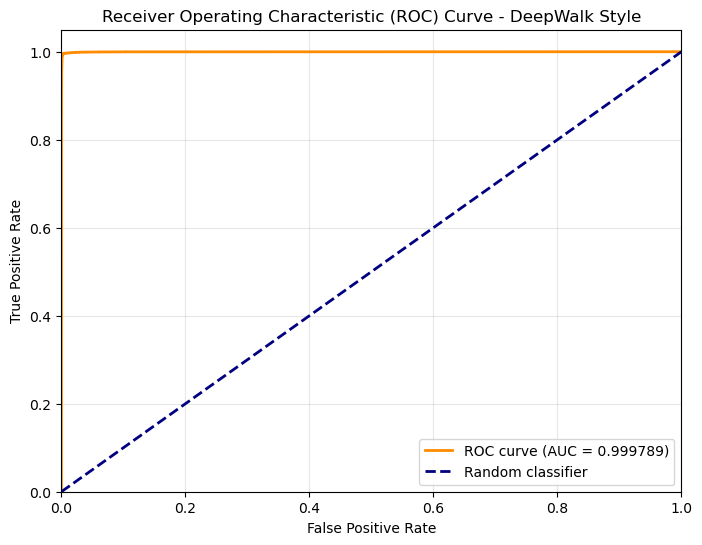

In [ ]:
# 计算ROC曲线
fpr, tpr, thresholds = roc_curve(y_true, y_pred)

# 绘制AUC曲线
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc:.6f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - DeepWalk Style')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()
